In [1]:
from astropy import convolution
import numpy as np
import matplotlib.pyplot as plt
import re
from PIL import Image
import os
import math
from scipy.interpolate import CubicSpline
# %matplotlib ipympl

In [24]:
ccd_px_side_length_micron = 3.8
ccd_width_px = 4656
ccd_height_px = 3520
plate_scale = 206265 * 3.8 / (1000*1800) # arcsec/px

def four_px(w_px,h_px,wid,hei):
    lst = []
    if (w_px <0 or w_px >= wid or h_px < 0 or h_px >= hei):
        return lst
    wf = np.floor(w_px)
    wc = np.ceil(w_px)
    hf = np.floor(h_px)
    hc = np.ceil(h_px)
    if np.allclose(w_px,wf): 
        w_floor_res = 1
        w_ceil_res = 0
    else: 
        w_floor_res = np.round(w_px - wf,3)
        w_ceil_res = np.round(wc - w_px,3)
    if np.allclose(h_px,hf): 
        h_floor_res = 1
        h_ceil_res = 0
    else: 
        h_floor_res = np.round(h_px - hf,3)
        h_ceil_res = np.round(hc - h_px,3)    

    if (wf >= 0 and hf >= 0):
        lst.append([wf ,hf ,w_floor_res*h_floor_res])
    if (wc < wid and hf >= 0):
        lst.append([wc ,hf ,w_ceil_res*h_floor_res])
    if (wf >= 0 and hc < hei):
        lst.append([wf ,hc ,w_floor_res*h_ceil_res])
    if (wc < wid and hc < hei):
        lst.append([wc , hc ,w_ceil_res*h_ceil_res])
    return lst

def rotate(mat,ang):
    cw = int(mat.shape[1]/2 -1)
    ch = int(mat.shape[0]/2 -1)

    mat2 = np.zeros(mat.shape)
    ang = np.deg2rad(ang)
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            jj = cw + np.cos(ang)*(j-cw) - np.sin(ang)*(i-ch)
            ii = ch + np.sin(ang)*(j-cw) + np.cos(ang)*(i-ch)
            lst = four_px(np.round(jj,3),np.round(ii,3),mat.shape[1],mat.shape[0])
            for ls in lst:
                 mat2[int(ls[1]),int(ls[0])] += ls[2] * mat[i,j]
    return mat2

def rot(psf,ang,ang0):
    im = Image.fromarray(psf)
    im = im.rotate(ang0-ang)
    im = np.array(im)
    im = im/np.sum(im)
    return im

def micind_to_pxind(w_ind,h_ind,cw_mic,ch_mic,cw_mic_ind,ch_mic_ind,cw_px_ind,ch_px_ind,spacing_micron):
    w_mic = cw_mic + (w_ind - cw_mic_ind)*spacing_micron
    h_mic = ch_mic + (h_ind - ch_mic_ind)*spacing_micron
    w_px = w_mic/ccd_px_side_length_micron
    h_px = h_mic/ccd_px_side_length_micron
    w_px_ind = int(w_px-cw_mic/ccd_px_side_length_micron) + cw_px_ind 
    h_px_ind = int(h_px-ch_mic/ccd_px_side_length_micron) + ch_px_ind
    return int(w_px_ind),int(h_px_ind)

def parse_psf_metadata(file_path):
    f = open(file_path, 'r', encoding='utf-8')
    s = f.read()
    f.close()
    m = re.search(r'spacing is (\d+\.\d+)', s)
    spacing = float(m.group(1))
    m = re.search(r'Reference Coordinates: (\d+\.\d+E[+-]\d+), (\d+\.\d+E[+-]\d+)', s)
    cw_mic = float(m.group(1))*1000
    ch_mic = float(m.group(2))*1000
    m = re.search(r'Center point is: row (\d+), column (\d+)', s)
    ch_mic_ind = int(m.group(1))
    cw_mic_ind = int(m.group(2))
    return spacing,cw_mic,ch_mic,cw_mic_ind,ch_mic_ind

def convert_psf(file_path):
    spacing_micron,cw_mic,ch_mic,cw_mic_ind,ch_mic_ind = parse_psf_metadata(file_path)
    psf_mic = np.loadtxt(file_path,dtype=float,skiprows=18,encoding='utf-8')
    ker_size = int(np.ceil(psf_mic.shape[0] * spacing_micron / ccd_px_side_length_micron))
    if (ker_size % 2 == 0): ker_size += 1 
    ch_px_ind = ker_size/2 - 1
    cw_px_ind = ker_size/2 - 1
    psf_px = np.zeros((ker_size,ker_size))
    for i in range(psf_mic.shape[0]):
        for j in range(psf_mic.shape[1]):
            jj , ii = micind_to_pxind(j,i,cw_mic,ch_mic,cw_mic_ind,ch_mic_ind,cw_px_ind,ch_px_ind,spacing_micron)
            psf_px[ker_size-1-ii,jj] += psf_mic[i,j]
    r = np.sqrt(ch_mic**2 + cw_mic**2)/3.8
    ang0 = np.rad2deg(np.arctan2(ch_mic,cw_mic))
    psf_px = psf_px/math.fsum(np.ravel(psf_px))
    return psf_px, r, ang0

def iter_kernels(rs, x_max, y_max, x_grid, y_grid):
    x_lines = np.linspace(0, x_max, x_grid+1).astype(int)
    y_lines = np.linspace(0, y_max, y_grid+1).astype(int)
    x_cen = x_max/2
    y_cen = y_max/2
    for x_line_index in range(x_grid):
        for y_line_index in range(y_grid):
            x_curr_center = x_lines[x_line_index] + ((x_lines[x_line_index+1]-1 - x_lines[x_line_index])/2)
            y_curr_center = y_lines[y_line_index] + ((y_lines[y_line_index+1]-1 - x_lines[y_line_index])/2)
            x_rel = x_curr_center - x_cen
            y_rel = y_curr_center - y_cen
            dist_from_center = np.sqrt(((x_rel)**2) + ((y_rel)**2))
            r = rs[np.argmin(np.abs(rs - dist_from_center))]
            angle = np.arctan2(y_rel, x_rel)
            ret = {'x_min': x_lines[x_line_index],
                   'x_max': x_lines[x_line_index+1]-1,
                   'y_min': y_lines[y_line_index],
                   'y_max': y_lines[y_line_index+1]-1,
                   'r': r,
                   'angle': angle}
            yield ret

def get_shadow_by_col():
    a = np.fromfile('./fiffa_data/MAST_BFD17_ASI1600_GuideMode.dat',sep=' ')
    y = np.fromfile('./fiffa_data/MAST_BFD17_ASI1600_YCord.dat',sep=' ')
    w_vec0 = np.unique(y)
    eta_vec0 = []
    for w0 in w_vec0:
        eta_vec0.append(np.mean(a[y == w0]))
    w_vec_px = np.arange(0,ccd_width_px,1)
    w_vec_deg = (w_vec_px - int(ccd_width_px/2 - 1))* plate_scale / 3600
    cs = CubicSpline(w_vec0,eta_vec0)
    eta_vec = cs(w_vec_deg)/100
    eta_vec[eta_vec > 1] = 1
    eta_vec[eta_vec < 0] = 0
    return eta_vec


In [25]:
psf_u_lst = []
r_u_lst = []
ang0_u_lst = []

psf_o_lst = []
r_o_lst = []
ang0_o_lst = []

for i in range(17):
    file_path_u = os.path.join('..','new_psfs', str.format(r'PSF_Field{}_unobscured.txt',i+1))
    psf_u, r_u ,ang0_u = convert_psf(file_path_u)
    psf_u_lst.append(psf_u)
    r_u_lst.append(int(r_u))
    ang0_u_lst.append(ang0_u)

for i in range(2,17):
    file_path_o = os.path.join('..','new_psfs', str.format(r'PSF_Field{}_obscured.txt',i+1))
    psf_o, r_o ,ang0_o = convert_psf(file_path_o)
    psf_o_lst.append(psf_o)
    r_o_lst.append(int(r_o))
    ang0_o_lst.append(ang0_o)    


In [31]:
r_dict = {r: i for i, r in enumerate(r_o_lst)}
for i,r in enumerate(r_o_lst):
    file_name = os.path.join('..', 'kernels_o', str.format(r'r={}.npy',r))
    np.save(file_name , arr = psf_o_lst[r_dict[r]])

In [49]:
blocks = iter_kernels(r_lst,ccd_width_px,ccd_height_px,15,15)
r_dict = {r: i for i, r in enumerate(r_lst)}

In [50]:
for bl in blocks:
    file_name = os.path.join('.', 'kernels', str.format(r'{}:{}X{}:{}.npy',bl['y_min'],bl['y_max'],bl['x_min'],bl['x_max']))
    r = bl['r']
    ang = np.rad2deg(bl['angle'])
    psf = psf_lst[r_dict[r]]
    ang0 = ang0_lst[r_dict[r]]
    ker = rot(psf,ang,ang0)
    np.save(file_name,arr = ker)

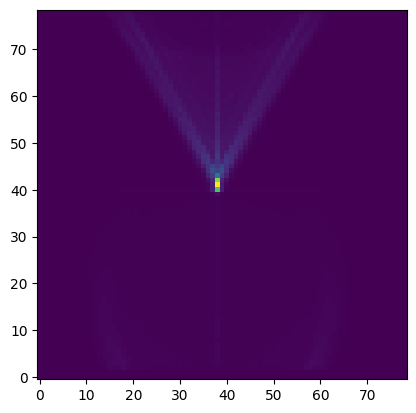

In [35]:
ker = np.load(r'..\kernels_o\r=4283.npy')
plt.imshow(ker,origin='lower')
plt.show()